# Fine-Tuning BERT on GLUE - QNLI

From [GLUE: A Multi-Task Benchmark and Analysis Platform for Natural Language Understanding - Wang et al.](https://arxiv.org/pdf/1804.07461):

The Stanford Question Answering Dataset (Rajpurkar et al. 2016) is a question-answering dataset consisting of question-paragraph pairs, where one of the sentences in the paragraph (drawn
from Wikipedia) contains the answer to the corresponding question (written by an annotator). We convert the task into sentence pair classification by forming a pair between each question and each
sentence in the corresponding context, and filtering out pairs with low lexical overlap between the question and the context sentence. The task is to determine whether the context sentence contains
the answer to the question. This modified version of the original task removes the requirement that the model select the exact answer, but also removes the simplifying assumptions that the answer
is always present in the input and that lexical overlap is a reliable cue. This process of recasting existing datasets into NLI is similar to methods introduced in White et al. (2017) and expanded
upon in Demszky et al. (2018). We call the converted dataset QNLI (Question-answering NLI).

## Configuration

In [1]:
import os

# Where to store the huggingface data. On the provided Jupyterlab instance that should be within the shared group folder.
os.environ['HF_HOME'] = '../groups/192.039-2024W/bert/huggingface/cache'

In [2]:
from pathlib import Path

from transformers import set_seed

# RANDOMNESS SEED
SEED = 42
set_seed(SEED)

# Which dataset to load
DATASET_NAME = "glue"
DATASET_TASK = "qnli"

PRE_TRAINED_CHECKPOINT = "google-bert/bert-base-uncased"

TRAIN_OUTPUT_DIR = (
    Path("../groups/192.039-2024W/bert") / "training" / f"{DATASET_NAME}-{DATASET_TASK}"
)

BATCH_SIZE = 32  # Original Paper claims to use 32 for GLUE tasks
NUM_EPOCHS = 5  # Original Paper claims to use 3 fine-tuning epochs for GLUE tasks

In [3]:
import torch

if torch.cuda.is_available():
  device = torch.device("cuda")
  device_count = torch.cuda.device_count()
  device_name = torch.cuda.get_device_name(0)

  print(f"There are {device_count} GPU(s) available.")
  print(f"GPU used: {device_name}")
  ! nvidia-smi -q --display=MEMORY,COMPUTE

else:
  print("No GPU available, using CPU.")
  device = torch.device("cpu")

There are 1 GPU(s) available.
GPU used: NVIDIA GeForce RTX 4060 Ti

==============NVSMI LOG==============

Timestamp                                 : Sun Jan  5 13:14:26 2025
Driver Version                            : 550.135
CUDA Version                              : 12.4

Attached GPUs                             : 1
GPU 00000000:07:00.0
    FB Memory Usage
        Total                             : 16380 MiB
        Reserved                          : 307 MiB
        Used                              : 1155 MiB
        Free                              : 14919 MiB
    BAR1 Memory Usage
        Total                             : 256 MiB
        Used                              : 27 MiB
        Free                              : 229 MiB
    Conf Compute Protected Memory Usage
        Total                             : 0 MiB
        Used                              : 0 MiB
        Free                              : 0 MiB
    Compute Mode                          : Default



## Dataset

In [4]:
# In the GLUE dataset different tasks have different accessor keys
_task_to_keys = {
    "cola": ("sentence", None),
    "mnli": ("premise", "hypothesis"),
    "mnli-mm": ("premise", "hypothesis"),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence", None),
    "stsb": ("sentence1", "sentence2"),
}

In [5]:
from datasets import load_dataset
import pandas as pd

dataset = load_dataset(DATASET_NAME, DATASET_TASK)
dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'sentence', 'label', 'idx'],
        num_rows: 104743
    })
    validation: Dataset({
        features: ['question', 'sentence', 'label', 'idx'],
        num_rows: 5463
    })
    test: Dataset({
        features: ['question', 'sentence', 'label', 'idx'],
        num_rows: 5463
    })
})

In [6]:
pd.DataFrame(dataset["train"]).sample(10)

,question,sentence,label,idx
64724,In what year did Robert Louis Stevenson die?,Mission work in Samoa had begun in late 1830 b...,1,64724
38119,How was the Everton FC's crest redesign receiv...,The redesign was poorly received by supporters...,0,38119
41924,Beyoncé was an honorary chair of the 2013 what?,She was also honorary chair of the 2013 Met Gala.,0,41924
42888,Who was the author of Conversations on the Plu...,Sarah Trimmer wrote a successful natural histo...,1,42888
47148,What is essential for the mating of the elemen...,Antennas are required by any radio receiver or...,0,47148
42142,What are some courses Eton offers in the summe...,These comparatively new developments will run ...,1,42142
19057,"What does ""open mouth operations"" mean?",Fractional deposit lending (changes in the res...,0,19057
69777,Who was the head of state of Swaziland after K...,"Following the elections of 1973, the constitut...",1,69777
32661,Why did Julius Caesar wish to invade Gaul?,When two local tribes began to migrate on a ro...,1,32661
61664,How is the city commonly abbreviated?,This motto was quickly adopted as a city nickn...,1,61664


In [7]:
unique_lables_in_dataset = pd.DataFrame(dataset["train"])["label"].unique()
num_labels = len(unique_lables_in_dataset)

print(f"{unique_lables_in_dataset=}")
print(f"{num_labels=}")

unique_lables_in_dataset=array([1, 0])
num_labels=2


## Tokenization

In [8]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_CHECKPOINT, do_lower_case="uncased" in PRE_TRAINED_CHECKPOINT)

BERT has a maximum sequence length of 512. We can check the sequence lengths resulting from tokenizing our dataset to see if our dataset exceeds this restriction of BERT:

In [9]:
first_sentence_key, second_sentence_key = _task_to_keys[DATASET_TASK]

if second_sentence_key == None:  # Simply tokenize sentence

    for split in dataset.keys():
        max_len = 0
        for sentence in dataset[split][first_sentence_key]:
            # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
            input_ids = tokenizer.encode(sentence, add_special_tokens=True)
            
            max_len = max(max_len, len(input_ids))
        

        print(f"Max length in {split=}: {max_len}")

else:  # Append both sentences via [SEP] and tokenize

    for split in dataset.keys():
        max_len = 0
        for sentence1, sentence2 in zip(dataset[split][first_sentence_key], dataset[split][second_sentence_key]):
            # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
            input_ids = tokenizer.encode(sentence1, sentence2,  add_special_tokens=True)
            
            max_len = max(max_len, len(input_ids))
        

        print(f"Max length in {split=}: {max_len}")


Token indices sequence length is longer than the specified maximum sequence length for this model (549 > 512). Running this sequence through the model will result in indexing errors


Max length in split='train': 550
Max length in split='validation': 250
Max length in split='test': 294


The training dataset contains sequences longer than the maximum sequence length for BERT. This will be handled via truncation by our tokenization function:

In [10]:
def tokenize_func(item):
    """Tokenize passed item. 
    
    Depending on dataset task the passed item will either contain one sentence or two sentences.
    In the last case the two sentences will be appended via a [SEP] token.
    """
    if second_sentence_key is None:
        return tokenizer(item[first_sentence_key], add_special_tokens=True, truncation=True)
    else:
        return tokenizer(item[first_sentence_key], item[second_sentence_key], add_special_tokens=True, truncation=True)

tokenized_dataset = dataset.map(tokenize_func, batched=True)

Map:   0%|          | 0/5463 [00:00<?, ? examples/s]

Here is an example of a tokenized dataset item:

In [11]:
dataset["train"][:1]

{'question': ['When did the third Digimon series begin?'],
 'sentence': ['Unlike the two seasons before it and most of the seasons that followed, Digimon Tamers takes a darker and more realistic approach to its story featuring Digimon who do not reincarnate after their deaths and more complex character development in the original Japanese.'],
 'label': [1],
 'idx': [0]}

In [12]:
tokenized_dataset["train"][:1]

{'question': ['When did the third Digimon series begin?'],
 'sentence': ['Unlike the two seasons before it and most of the seasons that followed, Digimon Tamers takes a darker and more realistic approach to its story featuring Digimon who do not reincarnate after their deaths and more complex character development in the original Japanese.'],
 'label': [1],
 'idx': [0],
 'input_ids': [[101,
   2043,
   2106,
   1996,
   2353,
   10667,
   16339,
   2078,
   2186,
   4088,
   1029,
   102,
   4406,
   1996,
   2048,
   3692,
   2077,
   2009,
   1998,
   2087,
   1997,
   1996,
   3692,
   2008,
   2628,
   1010,
   10667,
   16339,
   2078,
   24763,
   2869,
   3138,
   1037,
   9904,
   1998,
   2062,
   12689,
   3921,
   2000,
   2049,
   2466,
   3794,
   10667,
   16339,
   2078,
   2040,
   2079,
   2025,
   27788,
   10010,
   12556,
   2044,
   2037,
   6677,
   1998,
   2062,
   3375,
   2839,
   2458,
   1999,
   1996,
   2434,
   2887,
   1012,
   102]],
 'token_type_ids': 

Tokenization added the `input_ids` field, which contains the tokenized sentence with a `[CLS]`(101) and two `[SEP]`(102) tokens added. A `token_type_ids` field which indicates first and second portion of the inputs, if necessary. And an `attention_mask` for the given input.

### Dealing with Padding

Huggingface's `transformers` library provides a `DataCollatorWithPadding` class, which allows us to use dynamic padding.  
Dynamic padding will add `[PAD]` tokens to the length of the longest sequence within a batch, instead of padding to the maximum sequence length within the entire dataset.  
This will avoid unnecessary padding and therefore improve execution efficiency.

In [13]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Example: Select a few samples from the training set
samples = tokenized_dataset["train"][:3]
samples = {k: v for k, v in samples.items() if k not in ["idx", first_sentence_key, second_sentence_key]}  # Drop `idx` and `sentence` columns, as DataCollator can't process those.
pd.DataFrame(samples["input_ids"])

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,101,2043,2106,1996,2353,10667,16339,2078,2186,4088,...,2062.0,3375.0,2839.0,2458.0,1999.0,1996.0,2434.0,2887.0,1012.0,102.0
1,101,2029,7421,10274,2411,2031,3265,22742,2015,2195,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,101,2054,2048,2477,2515,3769,4842,7475,16985,5488,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# Apply padding using data_collator
batch = data_collator(samples)
pd.DataFrame(batch["input_ids"])


,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,101,2043,2106,1996,2353,10667,16339,2078,2186,4088,...,2062,3375,2839,2458,1999,1996,2434,2887,1012,102
1,101,2029,7421,10274,2411,2031,3265,22742,2015,2195,...,0,0,0,0,0,0,0,0,0,0
2,101,2054,2048,2477,2515,3769,4842,7475,16985,5488,...,0,0,0,0,0,0,0,0,0,0


We can see that `data_collator` will insert `[PAD]` (0) tokens to the maximum length of the passed batch of data items.

## Evaluation

The GLUE dataset specifies one or more evaluation metrics depending on the selected task.

In [15]:
import numpy as np
import evaluate

metric = evaluate.load(DATASET_NAME, DATASET_TASK)
metric

EvaluationModule(name: "glue", module_type: "metric", features: {'predictions': Value(dtype='int64', id=None), 'references': Value(dtype='int64', id=None)}, usage: """
Compute GLUE evaluation metric associated to each GLUE dataset.
Args:
    predictions: list of predictions to score.
        Each translation should be tokenized into a list of tokens.
    references: list of lists of references for each translation.
        Each reference should be tokenized into a list of tokens.
Returns: depending on the GLUE subset, one or several of:
    "accuracy": Accuracy
    "f1": F1 score
    "pearson": Pearson Correlation
    "spearmanr": Spearman Correlation
    "matthews_correlation": Matthew Correlation
Examples:

    >>> glue_metric = evaluate.load('glue', 'sst2')  # 'sst2' or any of ["mnli", "mnli_mismatched", "mnli_matched", "qnli", "rte", "wnli", "hans"]
    >>> references = [0, 1]
    >>> predictions = [0, 1]
    >>> results = glue_metric.compute(predictions=predictions, references=ref

Depending on the selected GLUE task we optimize for different evaluation metrics. See BERT paper p.6:

> F1 scores are reported for QQP and MRPC, Spearman correlations are reported for STS-B, and accuracy scores are reported for the other tasks. We exclude entries that use BERT as one of their components.

In [16]:
_task_to_metric = {
    "cola": "matthews_correlation",
    "mnli": "accuracy",
    "mnli-mm": "accuracy",
    "mrpc": "f1",
    "qnli": "accuracy",
    "qqp": "f1",
    "rte": "accuracy",
    "sst2": "accuracy",
    "stsb": "spearmanr",
}

metric_for_best_model = _task_to_metric[DATASET_TASK]

In [17]:
def get_metric_name_for_specific_task():
    """Helper function to derive the evaluation metric name for the specified GLUE task.

    The tasks specified by the GLUE benchmark use different evaluation metrics.
    Unfortunatly there is no easy way to derive there name after loading the corresponding metric function via HuggingFace's `evaluate` library.
    However we can simply do a "trial run" and expect the name key of its output.
    """
    output = metric.compute(
        predictions=[1, 0], references=[1, 1]
    )  # dummy input - we just want to inspect the returned dictionary.
    metric_names = output.keys()
    
    return list(metric_names)


metric_names = get_metric_name_for_specific_task()
print(f'We will use "{metric_names}" as an evaluation metric for the task {DATASET_TASK}')

We will use "['accuracy']" as an evaluation metric for the task qnli


In [18]:
assert metric_for_best_model in metric_names, "Metric to optimize for not found in evaluation metrics provided by GLUE"

# Training

In [19]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    PRE_TRAINED_CHECKPOINT,
    num_labels=num_labels,
    torch_dtype="auto",
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
from transformers import TrainingArguments

training_arguments = TrainingArguments(
    output_dir=TRAIN_OUTPUT_DIR,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    eval_strategy="steps",
    eval_steps=1000,
    save_strategy="steps",
    save_steps=1000,
    logging_strategy="steps",
    logging_steps=1000,
    num_train_epochs=NUM_EPOCHS,
    learning_rate=2e-5,  # Original paper uses best out of  5e-5, 4e-5, 3e-5, and 2e-5
    weight_decay=0.01,  # Original paper uses 0.01 on pre-training
    save_total_limit = 3,  # Keep at most the three checkpoints (latest + best one)
    load_best_model_at_end=True,
    metric_for_best_model=metric_for_best_model,
)

In [21]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    if DATASET_TASK != "stsb":
        predictions = np.argmax(predictions, axis=1)
    else:
        predictions = predictions[:, 0]
    return metric.compute(predictions=predictions, references=labels)

In [22]:
from transformers import Trainer

validation_key = "validation_mismatched" if DATASET_TASK == "mnli-mm" else "validation_matched" if DATASET_TASK == "mnli" else "validation"

trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset[validation_key],
    data_collator=data_collator,
    processing_class=tokenizer,
    compute_metrics=compute_metrics
)

In [23]:
torch.cuda.empty_cache()

print(f"--- {training_arguments.output_dir=}")
print(f"--- {training_arguments.metric_for_best_model=}")
training_summary = trainer.train()

--- training_arguments.output_dir='../groups/192.039-2024W/bert/training/glue-qnli'
--- training_arguments.metric_for_best_model='accuracy'


  0%|          | 0/16370 [00:00<?, ?it/s]

{'loss': 0.408, 'grad_norm': 5.035590648651123, 'learning_rate': 1.8778252901649362e-05, 'epoch': 0.31}


  0%|          | 0/171 [00:00<?, ?it/s]

{'eval_loss': 0.2824442386627197, 'eval_accuracy': 0.8848617975471352, 'eval_runtime': 15.8096, 'eval_samples_per_second': 345.55, 'eval_steps_per_second': 10.816, 'epoch': 0.31}
{'loss': 0.3248, 'grad_norm': 7.9803786277771, 'learning_rate': 1.755650580329872e-05, 'epoch': 0.61}


  0%|          | 0/171 [00:00<?, ?it/s]

{'eval_loss': 0.2805670499801636, 'eval_accuracy': 0.8817499542375984, 'eval_runtime': 11.6114, 'eval_samples_per_second': 470.485, 'eval_steps_per_second': 14.727, 'epoch': 0.61}
{'loss': 0.2967, 'grad_norm': 5.119344234466553, 'learning_rate': 1.6334758704948076e-05, 'epoch': 0.92}


  0%|          | 0/171 [00:00<?, ?it/s]

{'eval_loss': 0.2327309548854828, 'eval_accuracy': 0.9101226432363171, 'eval_runtime': 11.6546, 'eval_samples_per_second': 468.742, 'eval_steps_per_second': 14.672, 'epoch': 0.92}
{'loss': 0.2224, 'grad_norm': 3.0939462184906006, 'learning_rate': 1.5113011606597437e-05, 'epoch': 1.22}


  0%|          | 0/171 [00:00<?, ?it/s]

{'eval_loss': 0.2557765543460846, 'eval_accuracy': 0.9062786015010068, 'eval_runtime': 16.0961, 'eval_samples_per_second': 339.399, 'eval_steps_per_second': 10.624, 'epoch': 1.22}
{'loss': 0.195, 'grad_norm': 8.610628128051758, 'learning_rate': 1.3891264508246794e-05, 'epoch': 1.53}


  0%|          | 0/171 [00:00<?, ?it/s]

{'eval_loss': 0.23751363158226013, 'eval_accuracy': 0.9141497345780707, 'eval_runtime': 15.4616, 'eval_samples_per_second': 353.327, 'eval_steps_per_second': 11.06, 'epoch': 1.53}
{'loss': 0.201, 'grad_norm': 3.541438102722168, 'learning_rate': 1.2669517409896153e-05, 'epoch': 1.83}


  0%|          | 0/171 [00:00<?, ?it/s]

{'eval_loss': 0.23961345851421356, 'eval_accuracy': 0.9128683873329673, 'eval_runtime': 16.3388, 'eval_samples_per_second': 334.358, 'eval_steps_per_second': 10.466, 'epoch': 1.83}
{'loss': 0.1594, 'grad_norm': 5.338031768798828, 'learning_rate': 1.1447770311545512e-05, 'epoch': 2.14}


  0%|          | 0/171 [00:00<?, ?it/s]

{'eval_loss': 0.31283828616142273, 'eval_accuracy': 0.9112209408749771, 'eval_runtime': 16.2547, 'eval_samples_per_second': 336.088, 'eval_steps_per_second': 10.52, 'epoch': 2.14}
{'loss': 0.1168, 'grad_norm': 14.386604309082031, 'learning_rate': 1.0226023213194869e-05, 'epoch': 2.44}


  0%|          | 0/171 [00:00<?, ?it/s]

{'eval_loss': 0.30391186475753784, 'eval_accuracy': 0.914881933003844, 'eval_runtime': 16.1739, 'eval_samples_per_second': 337.766, 'eval_steps_per_second': 10.573, 'epoch': 2.44}
{'loss': 0.1205, 'grad_norm': 8.410170555114746, 'learning_rate': 9.004276114844227e-06, 'epoch': 2.75}


  0%|          | 0/171 [00:00<?, ?it/s]

{'eval_loss': 0.3115503191947937, 'eval_accuracy': 0.9112209408749771, 'eval_runtime': 16.0631, 'eval_samples_per_second': 340.095, 'eval_steps_per_second': 10.645, 'epoch': 2.75}
{'loss': 0.1132, 'grad_norm': 2.536112070083618, 'learning_rate': 7.782529016493586e-06, 'epoch': 3.05}


  0%|          | 0/171 [00:00<?, ?it/s]

{'eval_loss': 0.3802693486213684, 'eval_accuracy': 0.9119531393007505, 'eval_runtime': 16.2314, 'eval_samples_per_second': 336.57, 'eval_steps_per_second': 10.535, 'epoch': 3.05}
{'loss': 0.0747, 'grad_norm': 2.296729803085327, 'learning_rate': 6.560781918142944e-06, 'epoch': 3.36}


  0%|          | 0/171 [00:00<?, ?it/s]

{'eval_loss': 0.3942102789878845, 'eval_accuracy': 0.9123192385136372, 'eval_runtime': 16.1683, 'eval_samples_per_second': 337.883, 'eval_steps_per_second': 10.576, 'epoch': 3.36}
{'loss': 0.0759, 'grad_norm': 2.495047092437744, 'learning_rate': 5.339034819792304e-06, 'epoch': 3.67}


  0%|          | 0/171 [00:00<?, ?it/s]

{'eval_loss': 0.3836275637149811, 'eval_accuracy': 0.9088412959912137, 'eval_runtime': 16.151, 'eval_samples_per_second': 338.246, 'eval_steps_per_second': 10.588, 'epoch': 3.67}
{'loss': 0.0749, 'grad_norm': 33.62152862548828, 'learning_rate': 4.117287721441662e-06, 'epoch': 3.97}


  0%|          | 0/171 [00:00<?, ?it/s]

{'eval_loss': 0.3924527168273926, 'eval_accuracy': 0.9136005857587406, 'eval_runtime': 16.2699, 'eval_samples_per_second': 335.773, 'eval_steps_per_second': 10.51, 'epoch': 3.97}
{'loss': 0.0491, 'grad_norm': 31.06774139404297, 'learning_rate': 2.8955406230910206e-06, 'epoch': 4.28}


  0%|          | 0/171 [00:00<?, ?it/s]

{'eval_loss': 0.4592088460922241, 'eval_accuracy': 0.9123192385136372, 'eval_runtime': 16.2839, 'eval_samples_per_second': 335.484, 'eval_steps_per_second': 10.501, 'epoch': 4.28}
{'loss': 0.0484, 'grad_norm': 1.7823187112808228, 'learning_rate': 1.6737935247403788e-06, 'epoch': 4.58}


  0%|          | 0/171 [00:00<?, ?it/s]

{'eval_loss': 0.46036460995674133, 'eval_accuracy': 0.9134175361522973, 'eval_runtime': 16.0863, 'eval_samples_per_second': 339.605, 'eval_steps_per_second': 10.63, 'epoch': 4.58}
{'loss': 0.0483, 'grad_norm': 34.86168670654297, 'learning_rate': 4.5204642638973736e-07, 'epoch': 4.89}


  0%|          | 0/171 [00:00<?, ?it/s]

{'eval_loss': 0.44440314173698425, 'eval_accuracy': 0.9146988833974007, 'eval_runtime': 16.1817, 'eval_samples_per_second': 337.604, 'eval_steps_per_second': 10.568, 'epoch': 4.89}
{'train_runtime': 5297.4735, 'train_samples_per_second': 98.861, 'train_steps_per_second': 3.09, 'train_loss': 0.1554638878921947, 'epoch': 5.0}


In [24]:
training_summary

TrainOutput(global_step=16370, training_loss=0.1554638878921947, metrics={'train_runtime': 5297.4735, 'train_samples_per_second': 98.861, 'train_steps_per_second': 3.09, 'total_flos': 2.7216140760897e+16, 'train_loss': 0.1554638878921947, 'epoch': 5.0})

We can call `trainer.evaluate()` to check that the `trainer` instance did indeed reload the model checkpoint with the highest evaluation score:

In [25]:
best_model_evaluation = trainer.evaluate()
best_model_evaluation

  0%|          | 0/171 [00:00<?, ?it/s]

{'eval_loss': 0.30391186475753784,
 'eval_accuracy': 0.914881933003844,
 'eval_runtime': 15.8736,
 'eval_samples_per_second': 344.156,
 'eval_steps_per_second': 10.773,
 'epoch': 5.0}

In [29]:
training_history = pd.DataFrame(trainer.state.log_history)
training_history.groupby("step").first()

,loss,grad_norm,learning_rate,epoch,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
step,,,,,,,,,,,,,,
1000,0.4080,5.035591,1.877825e-05,0.305437,0.282444,0.884862,15.8096,345.550,10.816,NaN,NaN,NaN,NaN,NaN
2000,0.3248,7.980379,1.755651e-05,0.610874,0.280567,0.881750,11.6114,470.485,14.727,NaN,NaN,NaN,NaN,NaN
3000,0.2967,5.119344,1.633476e-05,0.916310,0.232731,0.910123,11.6546,468.742,14.672,NaN,NaN,NaN,NaN,NaN
4000,0.2224,3.093946,1.511301e-05,1.221747,0.255777,0.906279,16.0961,339.399,10.624,NaN,NaN,NaN,NaN,NaN
5000,0.1950,8.610628,1.389126e-05,1.527184,0.237514,0.914150,15.4616,353.327,11.060,NaN,NaN,NaN,NaN,NaN
6000,0.2010,3.541438,1.266952e-05,1.832621,0.239613,0.912868,16.3388,334.358,10.466,NaN,NaN,NaN,NaN,NaN
7000,0.1594,5.338032,1.144777e-05,2.138057,0.312838,0.911221,16.2547,336.088,10.520,NaN,NaN,NaN,NaN,NaN
8000,0.1168,14.386604,1.022602e-05,2.443494,0.303912,0.914882,16.1739,337.766,10.573,NaN,NaN,NaN,NaN,NaN
9000,0.1205,8.410171,9.004276e-06,2.748931,0.311550,0.911221,16.0631,340.095,10.645,NaN,NaN,NaN,NaN,NaN


### Loss and Evaluation Metrics over Training Steps

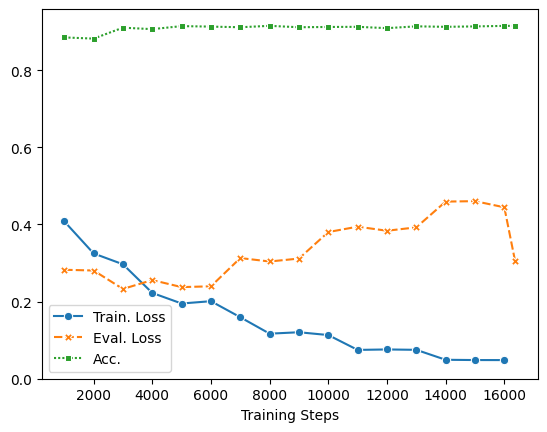

In [30]:
import seaborn as sns

data = training_history[["loss", "eval_loss", "step", f"eval_{metric_for_best_model}"]]
data.columns = ["Train. Loss", "Eval. Loss", "Training Steps", "Acc."]
data = pd.melt(data, ['Training Steps'])

plot = sns.lineplot(data=data, x="Training Steps", y="value", hue="variable", style="variable", markers=True)
plot.set_ylabel("")
plot.set_ylim((0, plot.get_ylim()[1]))
plot.legend(title="")

from IPython.display import Markdown, display
display(Markdown("### Loss and Evaluation Metrics over Training Steps"))

In [31]:
display(Markdown(f"### Best Model performance:"))
results = pd.DataFrame(
    best_model_evaluation.values(),
    index=best_model_evaluation.keys(),
    columns=["Our Model"],
).drop(
    # Drop runtime measurements
    index=["eval_runtime", "eval_samples_per_second", "eval_steps_per_second", "epoch"]
)
# Achieved scores from original BERT paper:
results["original BERT_BASE"] = ["-", 0.905]
results["original BERT_LARGE"] = ["-", 0.927]
print(f'"Our Model" based on {PRE_TRAINED_CHECKPOINT}, best performance on validation data.')
print('"BERT_BASE" and "BERT_LARGE" performance on GLUE testing data as reported in original paper.')
results

### Best Model performance:

"Our Model" based on google-bert/bert-base-uncased, best performance on validation data.
"BERT_BASE" and "BERT_LARGE" performance on GLUE testing data as reported in original paper.


,Our Model,original BERT_BASE,original BERT_LARGE
eval_loss,0.303912,-,-
eval_accuracy,0.914882,0.905,0.927
